In [1]:
#引入包
import time,json,joblib
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
path = 'data74989/'

In [ ]:
#函数    将地点城市名称转为对应的经纬度
from opencage.geocoder import OpenCageGeocode
def getGeCode(pot):
    key = '48e7654456e24b29b1c971bbfc0c81e5'
    geocoder = OpenCageGeocode(key)
    query = pot + ',Australian'
    res = geocoder.geocode(query)
    if len(res) > 0:
        results = dict(res[0])
        results = results['annotations']
        results = results['DMS']
        lat = str(results['lat'])
        lng = str(results['lng'])
        lat = lat.replace(lat[-1], '').replace(' ', '').replace('°', ' ').replace('\'', ' ').split(' ')
        lng = lng.replace(lng[-1], '').replace(' ', '').replace('°', ' ').replace('\'', ' ').split(' ')

        lat = (float(lat[0]) * 3600 + float(lat[1]) * 60 + float(lat[2]))
        lng = (float(lng[0]) * 3600 + float(lng[1]) * 60 + float(lng[2]))
    else:
        lat = None
        lng = None
    return ({
        "lat": lat,
        "lng": lng
    })


## 导入数据集

In [ ]:
# 导入数据集
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
len(train)

116368

## 查看一共多少个城市监测站

In [ ]:
# 将不同的Location转为经纬度
list_Location = train['Location'].unique()
dic_Location = {}
for city in list_Location:
    dic_Location[city] = getGeCode(city)
dic_Location

In [ ]:
# 储存为json数据
with open(path+'city.json','w') as file_obj:
    json.dump(dic_Location,file_obj)

In [7]:
# 从json数据读取
with open(path+'city.json','r') as file_obj:
    dic_Location = json.load(file_obj)
dic_Location

{'Dartmoor': {'lat': 136489.6692, 'lng': 508280.13288},
 'Newcastle': {'lat': 135811.2276, 'lng': 521636.06376},
 'Albany': {'lat': 129916.49652, 'lng': 528874.47792},
 'Ballarat': {'lat': 135224.83836, 'lng': 517908.20796},
 'Uluru': {'lat': 135811.2276, 'lng': 521636.06376},
 'Bendigo': {'lat': 132282.31824, 'lng': 519328.575},
 'Cairns': {'lat': 119746.71576, 'lng': 416631.02688},
 'Townsville': {'lat': 69340.1058, 'lng': 528553.49112},
 'GoldCoast': {'lat': 100930.30272, 'lng': 552265.83936},
 'Sale': {'lat': 135160.70112, 'lng': 517657.9842},
 'PerthAirport': {'lat': 114960.18996, 'lng': 417483.31464},
 'NorahHead': {'lat': 135811.2276, 'lng': 521636.06376},
 'Watsonia': {'lat': 135656.98344, 'lng': 522255.68532},
 'Woomera': {'lat': 135811.2276, 'lng': 521636.06376},
 'NorfolkIsland': {'lat': 135811.2276, 'lng': 521636.06376},
 'Richmond': {'lat': 74630.54592, 'lng': 515315.13912},
 'Brisbane': {'lat': 98912.33316, 'lng': 550873.269},
 'Wollongong': {'lat': 123936.37956, 'lng': 5

# 使用当前城市的中值填充其数字列

In [ ]:
def drew_Histogram_of_fata(df,tag):
    numerical = df._get_numeric_data().columns
    # 绘图
    fig, ax =plt.subplots(5,3, figsize=(30,35))
    i=0;j=0;k=0
    while i<=4:
        while j<=2:
            sns.distplot(df[numerical[k]], ax=ax[i, j])
            j+=1;k+=1
        j=0;i+=1;
    plt.savefig(path+'处理缺省值'+tag+'分布.png')
    plt.show()

## 处理前分布

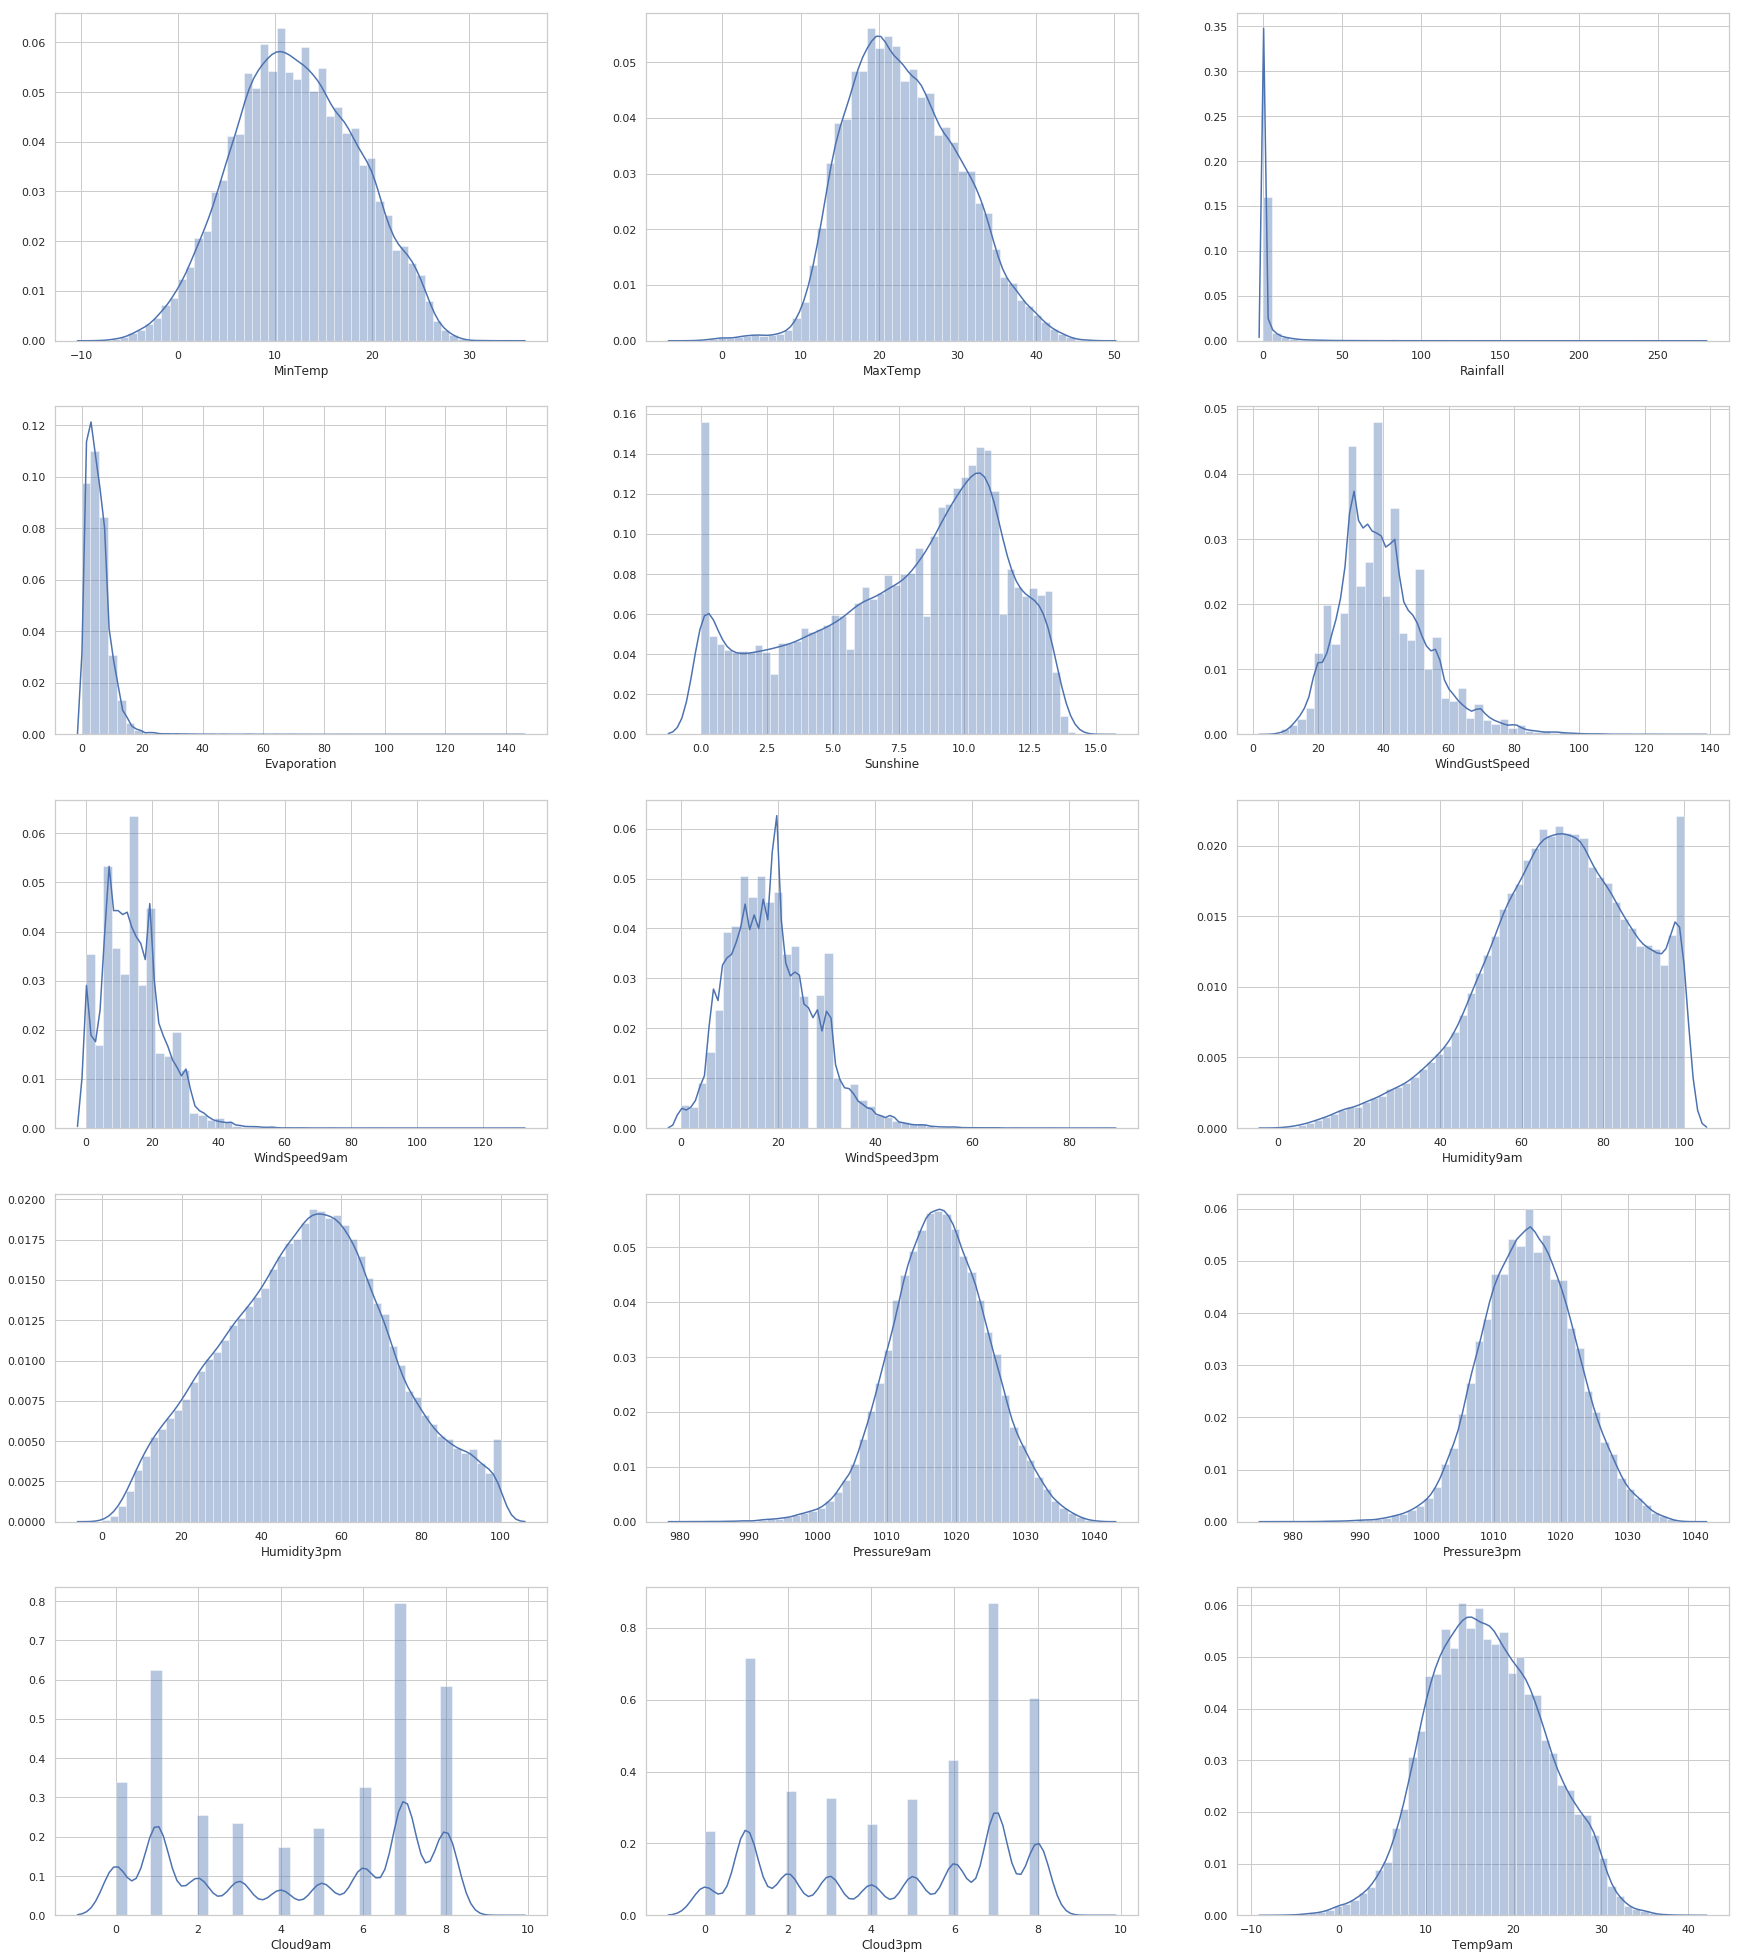

In [ ]:
drew_Histogram_of_fata(df=train,tag='前')

In [ ]:
def  median_fill_null(df):
    # 获取是数字的列
    numerical = df._get_numeric_data().columns
    # 不是数字的列
    categorical = set(df.columns) - set(numerical)
    # 不同Location的序列
    loc_for_miss = df["Location"].unique().tolist()
    # 储存中值的数据结构
    ls = []
    j=0
    while j<=len(numerical)-1:
        for i in range(len(loc_for_miss)):
            #大量异常值使用中值.median()
            ls.append(str(df.loc[df["Location"] == loc_for_miss[i], numerical[j]].median()))
        for i in range(len(loc_for_miss)):
            df.loc[df["Location"] == loc_for_miss[i], numerical[j]] = df.loc[df["Location"] == \
             loc_for_miss[i], numerical[j]].fillna(ls[i])
        j+=1
        df[numerical] = df[numerical].astype(float)
    return {
        'df':df,
        'numerical':numerical,
        'categorical':categorical,
        'loc_for_miss':loc_for_miss
    }


In [ ]:
# 使用字典保存全局数据结构
dict_train = median_fill_null(train)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## 处理空值后分布

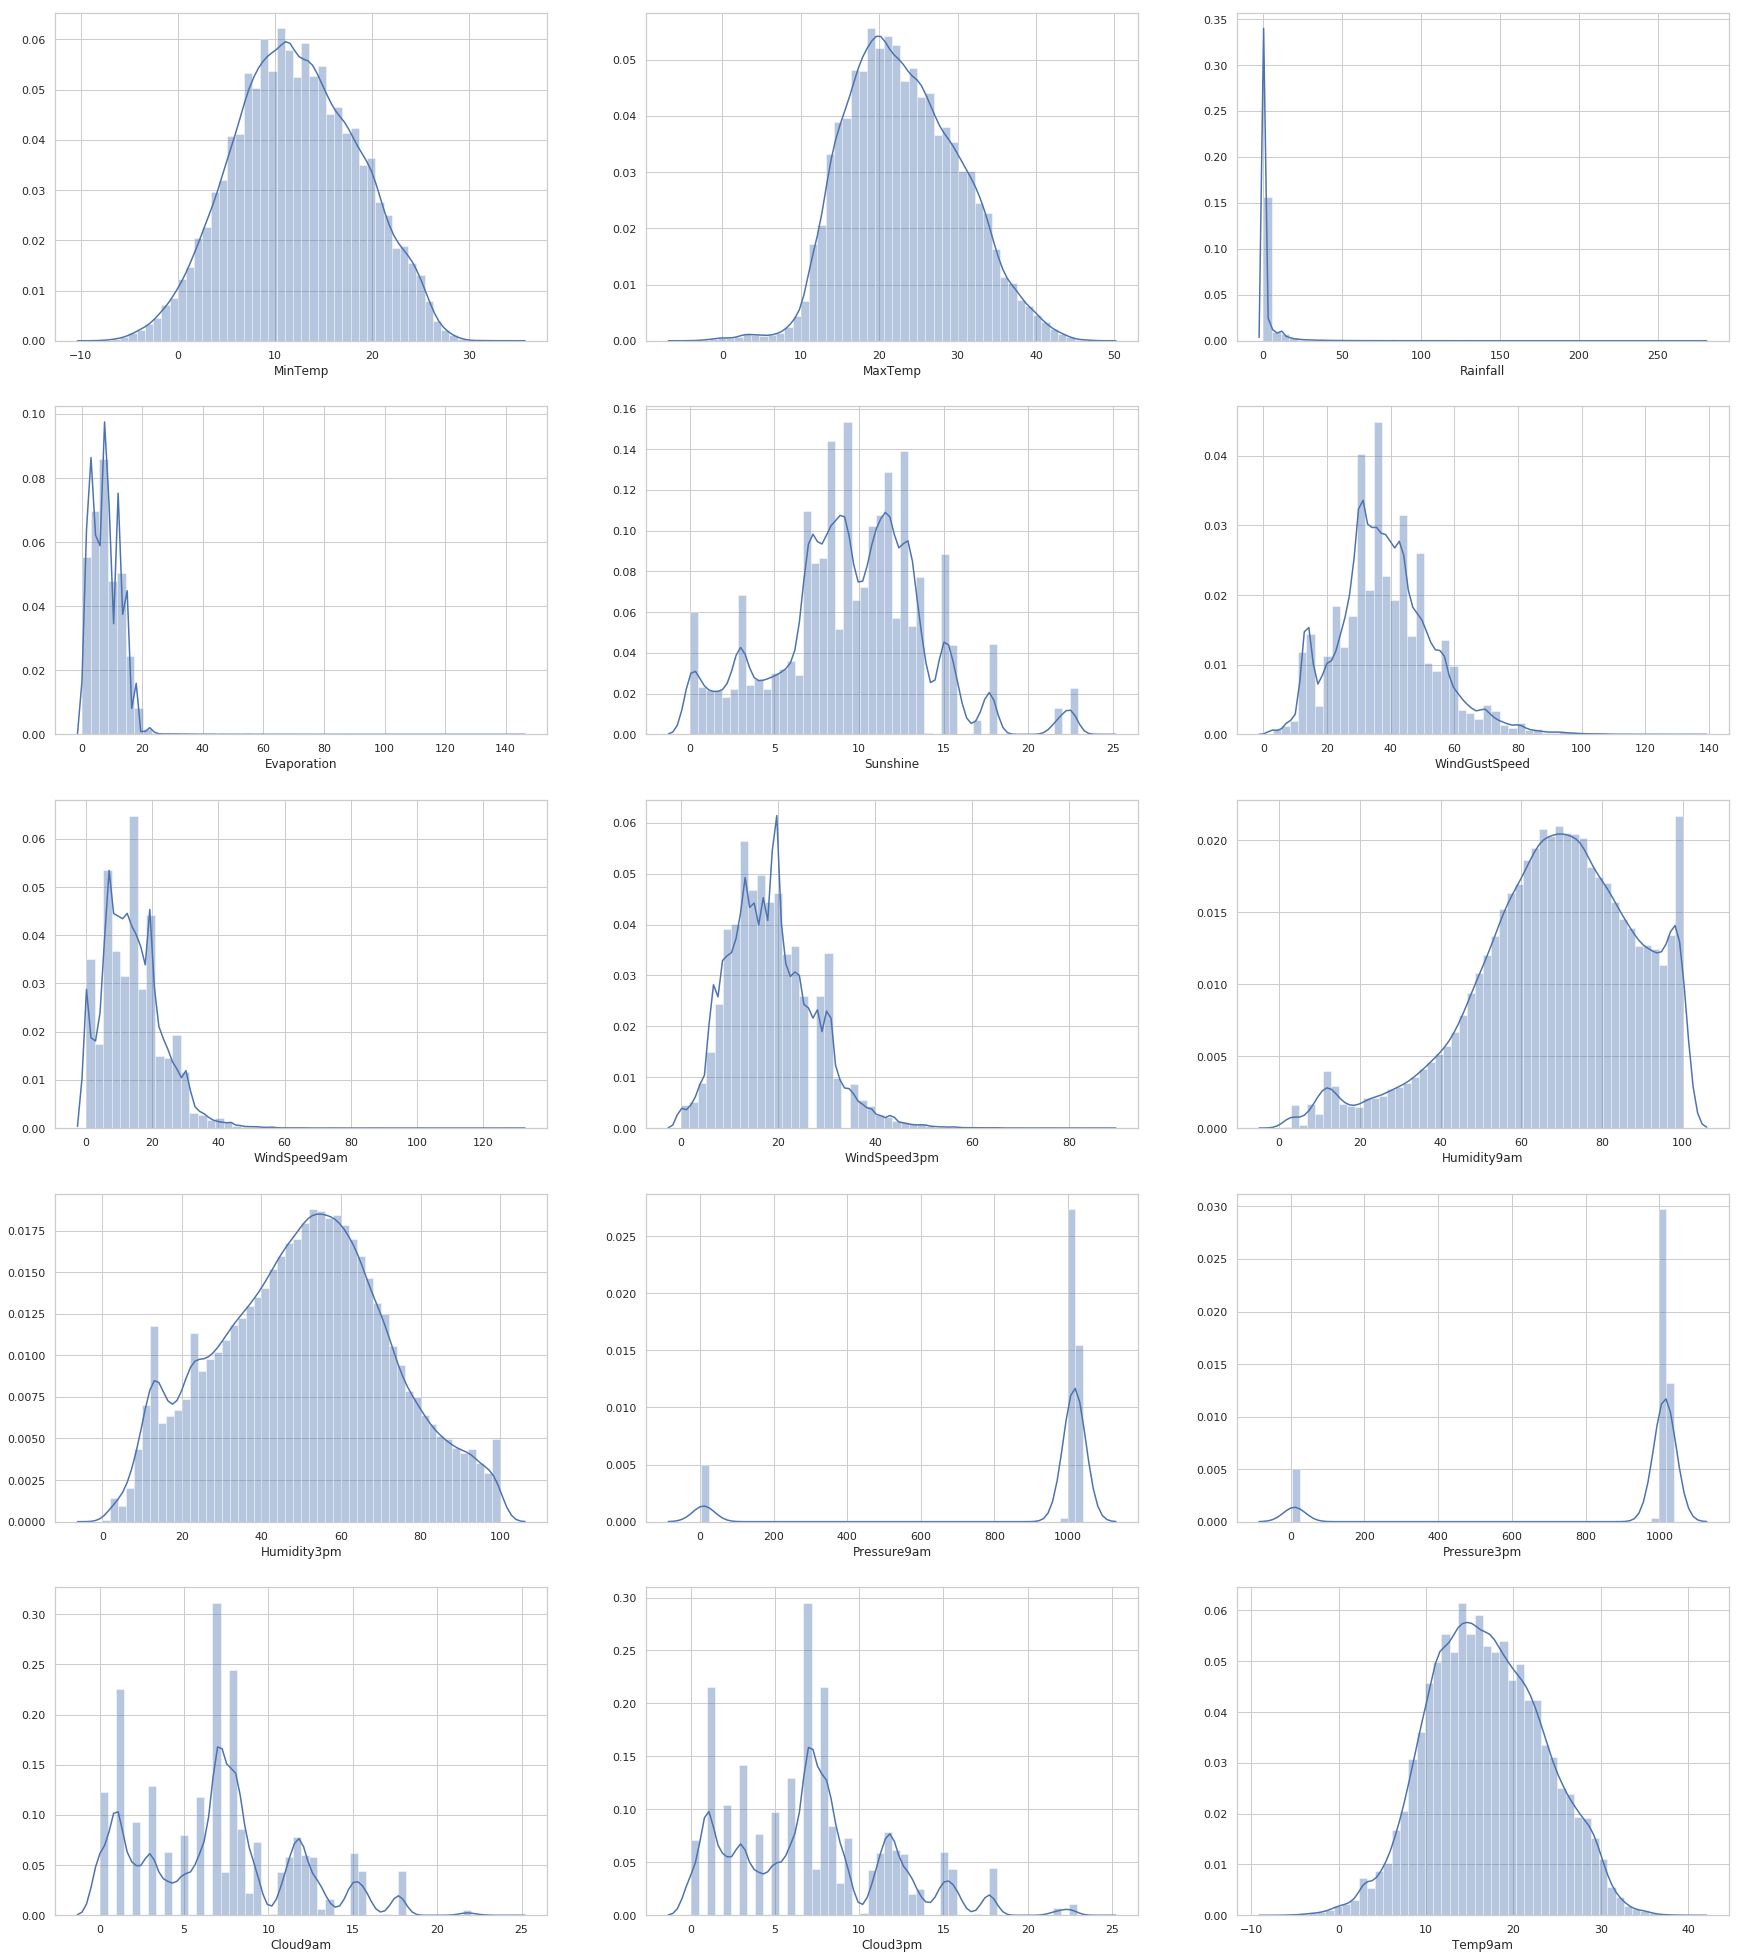

In [ ]:
drew_Histogram_of_fata(df=dict_train['df'],tag='后')

# 检查数字列异常值

## 箱型图特征分析
<image src="https://img2020.cnblogs.com/blog/1289939/202007/1289939-20200722164821837-2122904988.png">

In [ ]:
def drow_box_of_numerical(dict_data,isAfter=False):
    num_of_rows = 4
    num_of_cols = 4
    df = dict_data['df']
    numerical = dict_data['numerical']
    fig, ax = plt.subplots(4, 4, figsize=(15,15))
    i=0;j=0;k=0;
    while i<num_of_rows:
        while j<num_of_cols:
            sns.boxplot(df[numerical[k]], ax=ax[i, j])
            k+=1;j+=1
        j=0;i+=1
    if isAfter:
        title = '去除数字列异常值后'
    else:
        title = '去除数字列异常值前'
    plt.savefig(path+title+'.png')
    plt.show()

## 处理前

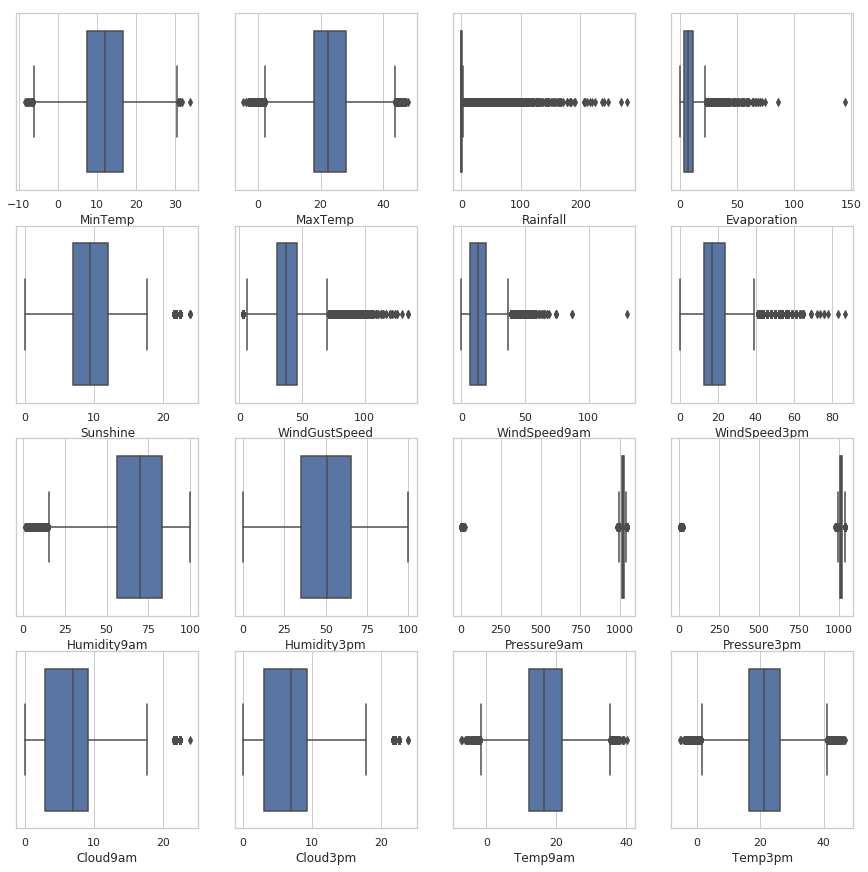

In [ ]:
drow_box_of_numerical(dict_data=dict_train,isAfter=False)

In [ ]:
def removeOutliers(dict_data):
    lsUpper = []
    lsLower = []
    df = dict_data['df']
    numerical = dict_data['numerical']
    for i in range(len(numerical)):
        # .quantile(0.25)分布数
        q1 = df[numerical[i]].quantile(0.25)
        q3 = df[numerical[i]].quantile(0.75)
        IQR = q3-q1
        minimum = q1 - 1.5 * IQR
        maximum = q3 + 1.5 * IQR
        df.loc[(df[numerical[i]] <= minimum), numerical[i]] = minimum
        df.loc[(df[numerical[i]] >= maximum), numerical[i]] = maximum
    dict_data['df'] = df
    return dict_data

In [ ]:
dict_train = removeOutliers(dict_train)

## 处理后

In [ ]:
len(dict_train['df'])

116368

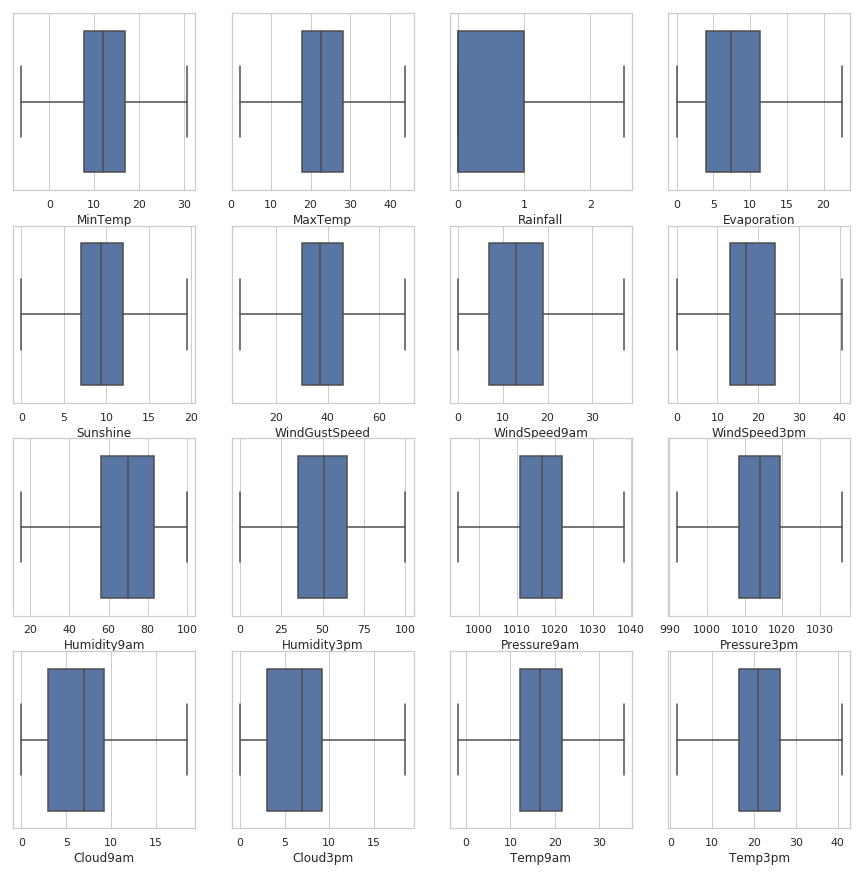

In [ ]:
drow_box_of_numerical(dict_data=dict_train,isAfter=True)

# 特征工程

In [ ]:
#函数  特征工程
def  feature_engineering(data):
    # 将日期转换为年，月，日
    data.insert(1, 'Year', 1, allow_duplicates=False)
    data.insert(1, 'Month', 1, allow_duplicates=False)
    data.insert(1, 'Day', 1, allow_duplicates=False)
    for i in range(len(data['Date'])):
        # 先转换为时间数组
        try:
            timeArray = time.strptime(data['Date'].iloc[i], "%Y-%m-%d")
        except ValueError as e:
            timeArray = time.strptime(data['Date'].iloc[i], "%Y/%m/%d")
        data['Year'].iloc[i] =timeArray.tm_year
        data['Month'].iloc[i] =timeArray.tm_mon
        data['Day'].iloc[i] =timeArray.tm_mday
    #将地点城市名称转为对应的经纬度
    # 从json数据读取
    with open(path+'city.json','r') as file_obj:
        dic_Location = json.load(file_obj)
    data.insert(1, 'lat', 1, allow_duplicates=False)
    data.insert(1, 'lng', 1, allow_duplicates=False)
    for i in range(len(data['Location'])):
        item = data['Location'].iloc[i]
        data['lat'].iloc[i] = dic_Location[item]['lat']
        data['lng'].iloc[i] = dic_Location[item]['lng']
    # 列补充与列删除
    data = data.drop(columns=["WindGustDir", "WindDir9am", "WindDir3pm", "Location", "Date"])
    data["AveTemp"] = (data["MinTemp"] + data["MaxTemp"]) / 2
    data["WindSpeed12pm"] = (data["WindSpeed3pm"] + data["WindSpeed9am"]) / 2
    data["Humidity12pm"] = (data["Humidity3pm"] + data["Humidity9am"]) / 2
    data["Pressure12pm"] = (data["Pressure3pm"] + data["Pressure9am"]) / 2
    data["Cloud12pm"] = (data["Cloud3pm"] + data["Cloud9am"]) / 2
    data["Temp12am"] = (data["Temp3pm"] + data["Temp9am"]) / 2
    # 将天气转化成int 填充空值为0
    try:
        data['RainTomorrow'].fillna('No', inplace = True)
        data['RainTomorrow'] = data['RainTomorrow'].map({'No':0, 'Yes':1})
        # 调整列序
        df_RainTomorrow = data['RainTomorrow']
        data = data.drop('RainTomorrow', axis=1)
        data.insert(len(data.columns), 'RainTomorrow', df_RainTomorrow)
    except:
        pass
    data['RainToday'].fillna('No', inplace = True)
    data['RainToday'] = data['RainToday'].map({'No':0, 'Yes':1})
    data.info()
    # 返回值pandas类型
    return data

In [ ]:
# 将第一次处理后的数据存储
train = feature_engineering(dict_train['df'])
train.to_csv(path+"temp_train_1.csv",index=False)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116368 entries, 0 to 116367
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lng            116368 non-null  float64
 1   lat            116368 non-null  float64
 2   Day            116368 non-null  int64  
 3   Month          116368 non-null  int64  
 4   Year           116368 non-null  int64  
 5   MinTemp        116368 non-null  float64
 6   MaxTemp        116368 non-null  float64
 7   Rainfall       116368 non-null  float64
 8   Evaporation    116368 non-null  float64
 9   Sunshine       116368 non-null  float64
 10  WindGustSpeed  116368 non-null  float64
 11  WindSpeed9am   116368 non-null  float64
 12  WindSpeed3pm   116368 non-null  float64
 13  Humidity9am    116368 non-null  float64
 14  Humidity3pm    116368 non-null  float64
 15  Pressure9am    116368 non-null  float64
 16  Pressure3pm    116368 non-null  float64
 17  Cloud9am       116368 non-nul

In [8]:
train = pd.read_csv(path+"temp_train_1.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116368 entries, 0 to 116367
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lng            116368 non-null  float64
 1   lat            116368 non-null  float64
 2   Day            116368 non-null  int64  
 3   Month          116368 non-null  int64  
 4   Year           116368 non-null  int64  
 5   MinTemp        116368 non-null  float64
 6   MaxTemp        116368 non-null  float64
 7   Rainfall       116368 non-null  float64
 8   Evaporation    116368 non-null  float64
 9   Sunshine       116368 non-null  float64
 10  WindGustSpeed  116368 non-null  float64
 11  WindSpeed9am   116368 non-null  float64
 12  WindSpeed3pm   116368 non-null  float64
 13  Humidity9am    116368 non-null  float64
 14  Humidity3pm    116368 non-null  float64
 15  Pressure9am    116368 non-null  float64
 16  Pressure3pm    116368 non-null  float64
 17  Cloud9am       116368 non-nul

# 找出效果最好的模型

In [9]:
# 分割测试集和训练集
train_n = np.asarray(train)
train_X = train_n[:,:-1].astype(float)
train_y = train_n[:,-1].astype(int)
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, train_size=0.7, random_state=0)

In [ ]:
train_y

array([1, 0, 0, ..., 1, 0, 0])

## 得到f1

In [4]:
def get_f1(y_hat, y_true, THRESHOLD=0.5):
	# '''
	# y_hat是未经过sigmoid函数激活的
	# 输出的f1为Marco-F1
	# '''
    epsilon = 1e-7
    y_hat = y_hat>THRESHOLD
    y_hat = np.int8(y_hat)
    tp = np.sum(y_hat*y_true, axis=0)
    fp = np.sum(y_hat*(1-y_true), axis=0)
    fn = np.sum((1-y_hat)*y_true, axis=0)
    p = tp/(tp+fp+epsilon)#epsilon的意义在于防止分母为0，否则当分母为0时python会报错
    r = tp/(tp+fn+epsilon)
    f1 = 2*p*r/(p+r+epsilon)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)
    return np.mean(f1)

## 绘制ROC曲线

In [5]:
def plot_curve(y_hat, y_true, name):
    fpr,tpr, threshold = roc_curve(y_hat, y_true)
    f1 = get_f1(y_hat, y_true)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label='{} {}'.format(name,np.round(f1,2)))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(path+'roc__'+name+'.png')
    plt.show()

## XGBClassifier

In [ ]:
start = time.time()
model = XGBClassifier(
            learning_rate =0.01,
            n_estimators=346,
            gamma=1.1345,
            subsample=0.8,
            reg_alpha=0.005,
            objective= 'binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=27
            )
parameters={
            'max_depth':range(2,10,1),
            'min_child_weight':range(5, 21, 1),
            'subsample':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
# 使用gpu
parameters['tree_method'] = ['gpu_hist']
method=GridSearchCV(estimator= model,param_grid=parameters,
                    cv=5,refit= True,scoring='f1_micro')
# method = XGBC(n_estimators=346,gamma=1.1345)
method.fit(train_X,train_y)
res = method.predict(test_X)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

In [ ]:
# 保存模型
joblib.dump(method, path+'XGBClassifier.model')

['work/home/aistudio/data/data74989/XGBClassifier.model']

In [13]:
# 模型加载
method = joblib.load(path+'XGBClassifier.model')
res = method.predict(test_X)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
print("f1值 %.5f" %(f1))

f1值 0.83815


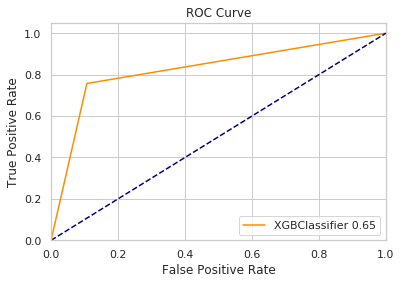

In [ ]:
plot_curve(res,test_y,'XGBClassifier')

## 随机森林回归

In [ ]:
# 随机森林回归
method = RandomForestClassifier(bootstrap= False, criterion= 'entropy', min_samples_split= 4, n_estimators= 200, random_state=0)
start = time.time()
method.fit(train_X,train_y)
res = method.predict(test_X)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

运行时间 39.72
f1值 0.61063


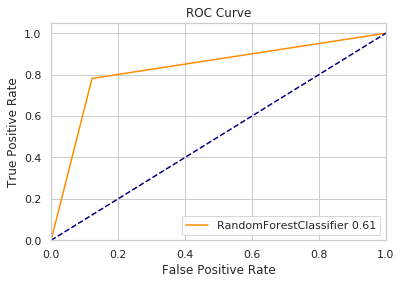

In [ ]:
plot_curve(res,test_y,'RandomForestClassifier')

## 线性回归

In [ ]:
# 线性回归
method = LinearRegression()
start = time.time()
method.fit(train_X,train_y)
res = method.predict(test_X).astype('int')
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

运行时间 0.12
f1值 0.01210


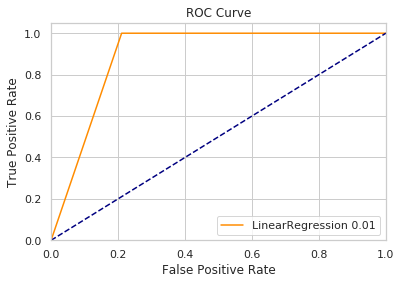

In [ ]:
plot_curve(res,test_y,'LinearRegression')

## SVC

In [ ]:
# SVC
from sklearn.svm import SVC
# for kernel in ["linear","poly","rbf","sigmoid"]:
for kernel in ["linear"]:
    method = SVC(kernel = kernel
                ,gamma="auto"
                ,degree = 1
                ,cache_size = 5000
                ,class_weight = {1:10} # "1"类的样本权重为10，隐含"0"类的样本权重为1
                )
    start = time.time()
    method.fit(train_X,train_y)
    res = method.predict(test_X)
    precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
    f1 = get_f1(res,test_y)
    end = time.time()
    print("运行时间 %.2f" %(end-start))
    print("f1值 %.5f" %(f1))

In [ ]:
test_y

array([0, 0, 0, ..., 0, 1, 0])

## 逻辑斯蒂回归

In [ ]:
# 逻辑斯蒂回归
method = LogisticRegression(max_iter=5000)
start = time.time()
method.fit(train_X,train_y)
res = method.predict(test_X).astype(int)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

运行时间 4.99
f1值 0.43874


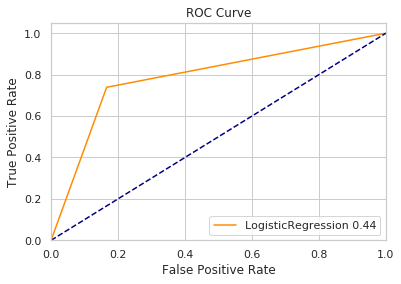

In [ ]:
plot_curve(res,test_y,'LogisticRegression')

## 梯度提升算法

In [ ]:
# 梯度提升算法
from sklearn.ensemble import GradientBoostingRegressor
start = time.time()
method = GradientBoostingRegressor(n_estimators=100, warm_start=True,learning_rate=0.01, max_depth=10, random_state=0, loss='ls')
method.fit(train_X,train_y)
res = method.predict(test_X)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

运行时间 151.53
f1值 0.48708


In [ ]:
plot_curve(res,test_y,'GradientBoostingRegressor')

## 使用决策树解决回归问题

In [ ]:
#使用决策树解决回归问题
from sklearn.tree import DecisionTreeClassifier
# 找出f1值最大的
f1 = 0
ind = 0
start = time.time()
for i in range(1,15):
    method=DecisionTreeClassifier(max_depth=i)
    method.fit(train_X,train_y)
    res = method.predict(test_X)
    precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
    if get_f1(res,test_y) > f1:
        f1 = get_f1(res,test_y)
        ind = i
end = time.time()
print("运行时间 %.2f" %(end-start))
print('最大的'+"f1值 %.5f max_depth=%d" %(f1,ind))

运行时间 16.08
最大的f1值 0.57431 max_depth=9


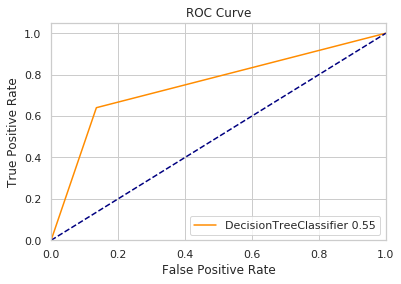

In [ ]:
plot_curve(res,test_y,'DecisionTreeClassifier')

## 贝叶斯

In [14]:
# 贝叶斯
from sklearn.naive_bayes import GaussianNB
method = GaussianNB()
start = time.time()
method.fit(train_X,train_y)
res = method.predict(test_X).astype(int)
precision = 1-(np.sum(np.abs(res-test_y)) / len(res))
f1 = get_f1(res,test_y)
end = time.time()
print("运行时间 %.2f" %(end-start))
print("f1值 %.5f" %(f1))

运行时间 0.06
f1值 0.56476


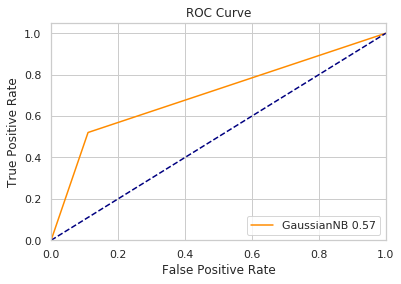

In [ ]:
plot_curve(res,test_y,'GaussianNB')

# 使用效果最好的模型进行预测

In [ ]:
# 数据集准备
test = pd.read_csv(path+'test.csv')
dict_test = median_fill_null(df=test)
dict_test = removeOutliers(dict_data=dict_test)
temp_test = dict_test['df'].copy()
ntest = feature_engineering(temp_test)
ntest.to_csv(path+"new_test.csv",index=False)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
ntest = pd.read_csv(path+'new_test.csv')
ntest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29092 entries, 0 to 29091
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lng            29092 non-null  float64
 1   lat            29092 non-null  float64
 2   Day            29092 non-null  int64  
 3   Month          29092 non-null  int64  
 4   Year           29092 non-null  int64  
 5   MinTemp        29092 non-null  float64
 6   MaxTemp        29092 non-null  float64
 7   Rainfall       29092 non-null  float64
 8   Evaporation    29092 non-null  float64
 9   Sunshine       29092 non-null  float64
 10  WindGustSpeed  29092 non-null  float64
 11  WindSpeed9am   29092 non-null  float64
 12  WindSpeed3pm   29092 non-null  float64
 13  Humidity9am    29092 non-null  float64
 14  Humidity3pm    29092 non-null  float64
 15  Pressure9am    29092 non-null  float64
 16  Pressure3pm    29092 non-null  float64
 17  Cloud9am       29092 non-null  float64
 18  Cloud3

In [ ]:
nntest = np.asarray(ntest)
res = method.predict(nntest).astype(int)
res

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
len(res)

29092

## 生成结果并保存

In [ ]:
# 生成结果并保存
import datetime
last_res = pd.read_csv(path+'test.csv')
last_res = pd.DataFrame(last_res['Date'])
last_res.insert(1, 'RainTomorrow', res, allow_duplicates=False)
last_res['RainTomorrow'] = last_res['RainTomorrow'].astype(int)
last_res['RainTomorrow'] = last_res['RainTomorrow'].map({1:'Yes',0:'No'})
last_res.to_csv(path+"0423.csv",index=False)